# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [7]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input/R5KrjnANiKVhLWAkpXhNBe'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

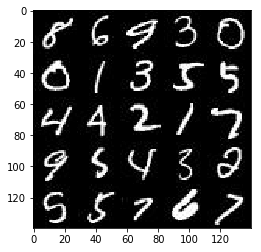

In [9]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

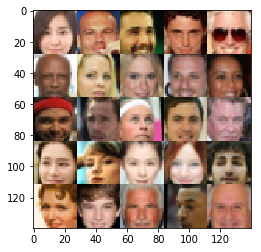

In [10]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [12]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [13]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5994... Generator Loss: 0.4160
Epoch 1/2... Discriminator Loss: 0.5368... Generator Loss: 2.6363
Epoch 1/2... Discriminator Loss: 0.6939... Generator Loss: 1.9310
Epoch 1/2... Discriminator Loss: 1.8263... Generator Loss: 0.5127
Epoch 1/2... Discriminator Loss: 1.0311... Generator Loss: 1.0368
Epoch 1/2... Discriminator Loss: 1.5684... Generator Loss: 2.1711
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 1.1492
Epoch 1/2... Discriminator Loss: 1.2541... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 1.1551... Generator Loss: 0.8615
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 1.1384


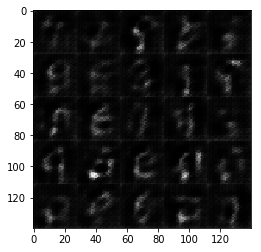

Epoch 1/2... Discriminator Loss: 1.2794... Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 1.0983... Generator Loss: 0.9348
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 1.0676
Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 0.9691
Epoch 1/2... Discriminator Loss: 1.3517... Generator Loss: 1.6973
Epoch 1/2... Discriminator Loss: 1.4069... Generator Loss: 0.5641
Epoch 1/2... Discriminator Loss: 1.5003... Generator Loss: 0.5193
Epoch 1/2... Discriminator Loss: 1.2399... Generator Loss: 0.9851
Epoch 1/2... Discriminator Loss: 1.1410... Generator Loss: 1.1705
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 0.7131


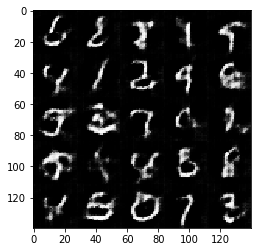

Epoch 1/2... Discriminator Loss: 1.5403... Generator Loss: 0.4607
Epoch 1/2... Discriminator Loss: 1.1391... Generator Loss: 0.9712
Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 0.8538
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 1.2751
Epoch 1/2... Discriminator Loss: 1.1460... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 1.3250... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 1.1492... Generator Loss: 1.0508
Epoch 1/2... Discriminator Loss: 1.2731... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 1.4291... Generator Loss: 0.5049
Epoch 1/2... Discriminator Loss: 1.2520... Generator Loss: 1.1449


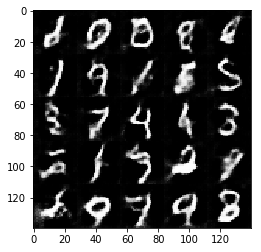

Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 0.7841
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.5754
Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 1.0269
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 0.7111
Epoch 1/2... Discriminator Loss: 1.6820... Generator Loss: 0.3809
Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 0.8371
Epoch 1/2... Discriminator Loss: 1.5619... Generator Loss: 0.4265
Epoch 1/2... Discriminator Loss: 1.3264... Generator Loss: 0.5712
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.5296
Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 1.0162


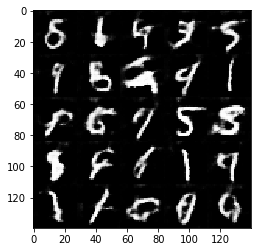

Epoch 1/2... Discriminator Loss: 1.1783... Generator Loss: 1.1455
Epoch 1/2... Discriminator Loss: 1.3598... Generator Loss: 0.5792
Epoch 1/2... Discriminator Loss: 1.0817... Generator Loss: 1.1022
Epoch 1/2... Discriminator Loss: 1.1962... Generator Loss: 1.2994
Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 0.5889
Epoch 1/2... Discriminator Loss: 1.1425... Generator Loss: 0.9276
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.5568
Epoch 2/2... Discriminator Loss: 1.0835... Generator Loss: 0.9443
Epoch 2/2... Discriminator Loss: 1.1008... Generator Loss: 1.2041
Epoch 2/2... Discriminator Loss: 1.0969... Generator Loss: 1.0451
Epoch 2/2... Discriminator Loss: 1.3642... Generator Loss: 0.5433
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 1.1221
Epoch 2/2... Discriminator Loss: 1.2218... Generator Loss: 0.6734
Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 1.3595
Epoch 2/2... Discriminator Loss: 1.4171... Generator Loss: 1.8191
Epoch 2/2.

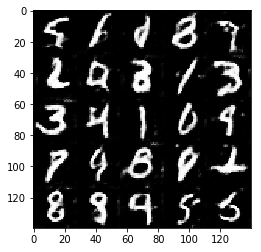

Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 0.7982
Epoch 2/2... Discriminator Loss: 1.2009... Generator Loss: 0.7661
Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.5902
Epoch 2/2... Discriminator Loss: 1.7837... Generator Loss: 0.3390
Epoch 2/2... Discriminator Loss: 1.1948... Generator Loss: 0.7337
Epoch 2/2... Discriminator Loss: 1.2973... Generator Loss: 1.3942
Epoch 2/2... Discriminator Loss: 1.1172... Generator Loss: 1.5726
Epoch 2/2... Discriminator Loss: 1.4235... Generator Loss: 0.5062
Epoch 2/2... Discriminator Loss: 1.1242... Generator Loss: 1.3368
Epoch 2/2... Discriminator Loss: 1.5536... Generator Loss: 0.4291


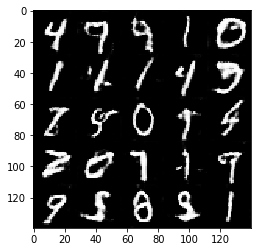

Epoch 2/2... Discriminator Loss: 1.1424... Generator Loss: 0.7706
Epoch 2/2... Discriminator Loss: 1.6531... Generator Loss: 0.3787
Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 0.8326
Epoch 2/2... Discriminator Loss: 1.3006... Generator Loss: 1.9674
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 0.9350
Epoch 2/2... Discriminator Loss: 1.0970... Generator Loss: 0.9421
Epoch 2/2... Discriminator Loss: 1.0557... Generator Loss: 0.9661
Epoch 2/2... Discriminator Loss: 1.3899... Generator Loss: 0.6694
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.8693
Epoch 2/2... Discriminator Loss: 1.1030... Generator Loss: 0.8045


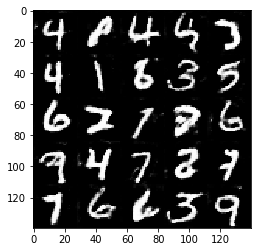

Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 1.2153... Generator Loss: 0.7078
Epoch 2/2... Discriminator Loss: 1.3101... Generator Loss: 0.6599
Epoch 2/2... Discriminator Loss: 1.3485... Generator Loss: 1.8805
Epoch 2/2... Discriminator Loss: 1.4085... Generator Loss: 0.5376
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 1.0683
Epoch 2/2... Discriminator Loss: 1.5774... Generator Loss: 2.3137
Epoch 2/2... Discriminator Loss: 1.2966... Generator Loss: 0.6487
Epoch 2/2... Discriminator Loss: 1.2946... Generator Loss: 1.2664
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 0.7778


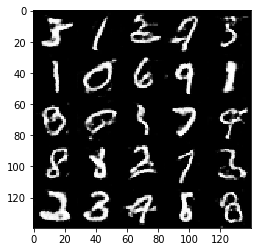

Epoch 2/2... Discriminator Loss: 1.2114... Generator Loss: 0.7202
Epoch 2/2... Discriminator Loss: 1.0974... Generator Loss: 0.9594
Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 0.6866
Epoch 2/2... Discriminator Loss: 1.2323... Generator Loss: 0.6835
Epoch 2/2... Discriminator Loss: 1.2499... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 1.2452... Generator Loss: 0.7195


In [19]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9523... Generator Loss: 0.3448
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 1.4246
Epoch 1/1... Discriminator Loss: 0.6822... Generator Loss: 1.7325
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 1.3630
Epoch 1/1... Discriminator Loss: 0.5265... Generator Loss: 2.6354
Epoch 1/1... Discriminator Loss: 0.6462... Generator Loss: 1.7241
Epoch 1/1... Discriminator Loss: 0.5624... Generator Loss: 2.3626
Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 1.5145
Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 3.5823


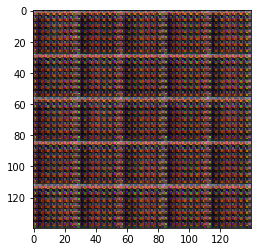

Epoch 1/1... Discriminator Loss: 0.4953... Generator Loss: 2.7659
Epoch 1/1... Discriminator Loss: 0.5057... Generator Loss: 2.4261
Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 1.8641
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.5011
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.8478
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 1.3190
Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 1.3076
Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 1.2514
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 0.8617... Generator Loss: 2.9755


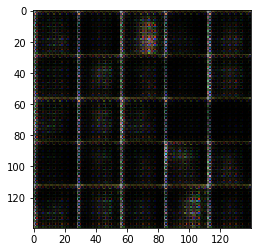

Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.6928
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.9331
Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 1.9331
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 1.6015
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 1.4059
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.5639
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 1.4259
Epoch 1/1... Discriminator Loss: 0.9241... Generator Loss: 1.2134
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.3085


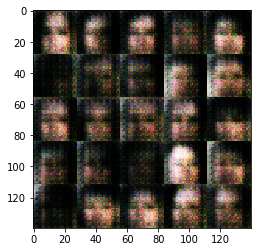

Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.2379
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 1.8934
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 1.9762
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.6860
Epoch 1/1... Discriminator Loss: 0.8079... Generator Loss: 1.6760
Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.2895
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.2929


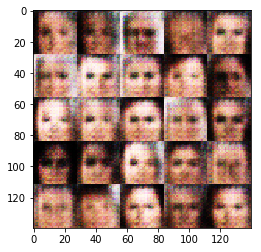

Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 1.5092
Epoch 1/1... Discriminator Loss: 0.7524... Generator Loss: 1.6843
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 1.0975... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 1.6395
Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 0.8945... Generator Loss: 1.3822
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.1684


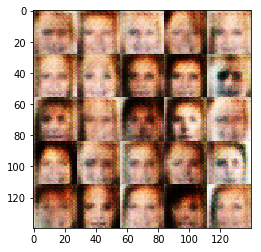

Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.6760
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 1.0028
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.1874
Epoch 1/1... Discriminator Loss: 0.7882... Generator Loss: 1.5353
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 2.8088
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 1.7795


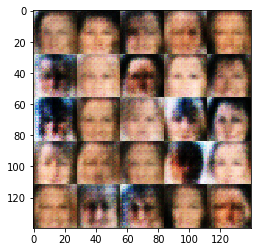

Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 1.2513
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.3902
Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 1.3468
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 1.3930


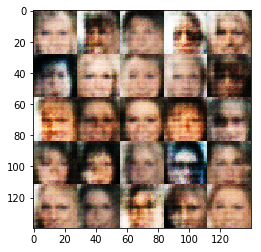

Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.3801
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.0558
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 1.6027
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.9861
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 0.9711... Generator Loss: 1.4564


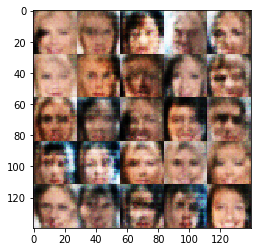

Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 1.7917
Epoch 1/1... Discriminator Loss: 1.0284... Generator Loss: 1.0616
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.6902
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.8873
Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 1.1693
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 1.1019
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 0.8263


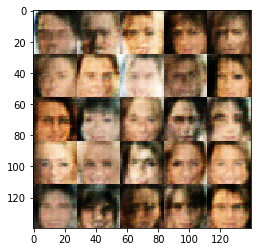

Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 1.2226
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 1.2126
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.6476


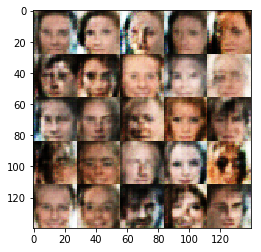

Epoch 1/1... Discriminator Loss: 1.0762... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.2120
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.9509
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 1.2316
Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 1.0655


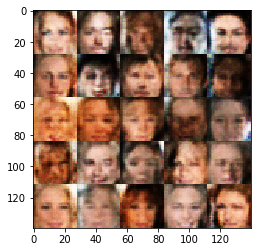

Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.8991
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 1.0933
Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.6216
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.9155


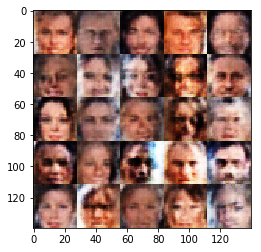

Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 1.1518
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.0784... Generator Loss: 1.3251
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.6567


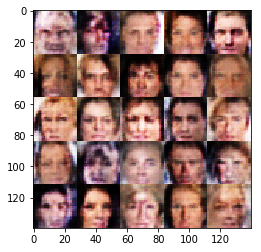

Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 1.1659
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 1.0378
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 1.7575
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 0.9885... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 1.2583
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.8923
Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 1.0811


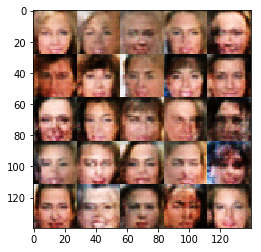

Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 1.0112
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.5808
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.5202
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 1.2286
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.1096
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.9048


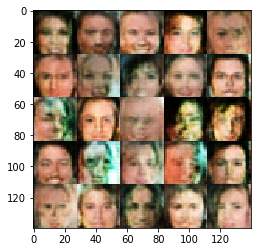

Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 1.0551
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 1.4318
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.0323
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.9712
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.7628


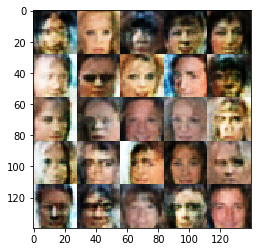

Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.0486... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.9480
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.0541


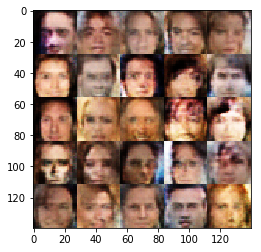

Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 1.0039
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 1.2534


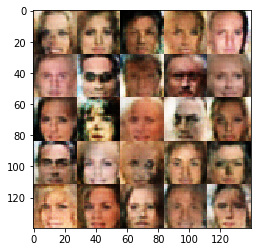

Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 1.0536
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.1010


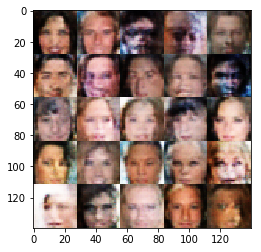

Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 1.3218
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 1.0015
Epoch 1/1... Discriminator Loss: 1.1071... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.1575... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.0441... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.9514


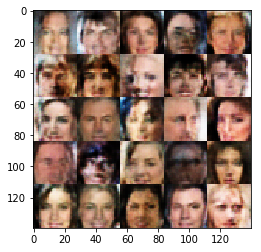

Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.5767
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 1.0407


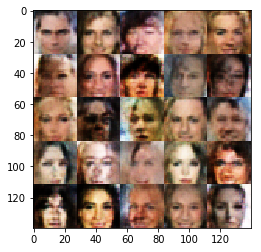

Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 1.1193
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.2577... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.4865
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.8243


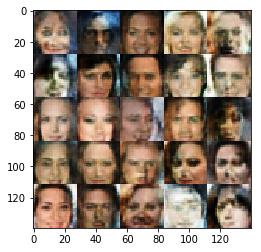

Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 1.2817
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.2342... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.2707
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 0.9013


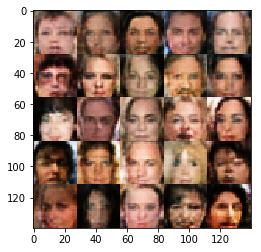

Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 1.0990
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.9796


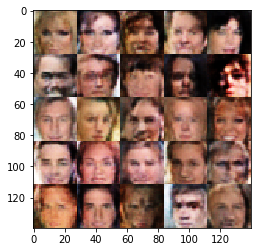

Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.4936
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 1.2040
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.6955


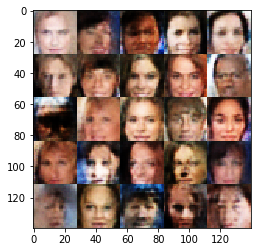

Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 1.5052
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.9795
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 1.0370


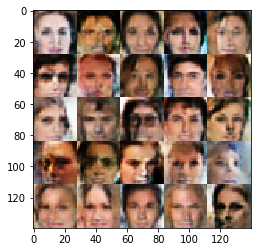

Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.9934
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.2718... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 1.0416
Epoch 1/1... Discriminator Loss: 1.0912... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.7129


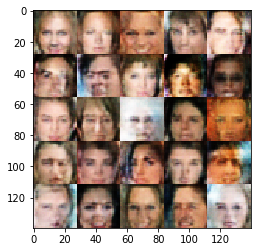

Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 1.2578
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 1.1344
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.2974... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.7414


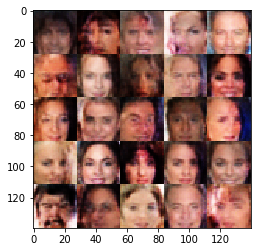

Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.8716


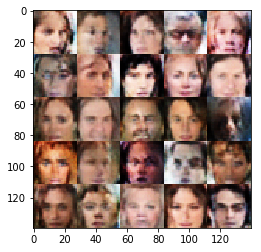

Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.6764
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 0.9318
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 0.9650


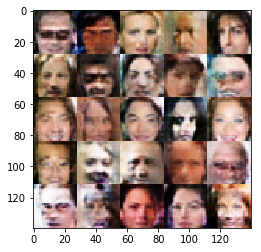

In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.